# Install

# Data

In [1]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob

In [2]:
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 128
EPOCHS = 10

In [4]:
labels_train_val = pd.read_csv('/kaggle/input/data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('/kaggle/input/data/test_list.txt')
labels_test.columns = ['Image_Index']
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

# labels_df.to_csv('/kaggle/working/newData.csv')
labels_df=labels_df[labels_df.Finding_Labels != 'No Finding']
#labels_df.head(3)

100%|██████████| 14/14 [00:00<00:00, 29.59it/s]


In [5]:

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('/kaggle/input/data/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
labels_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_000.png
5,00000003_001.png,[Hernia],1,3,74,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_001.png


In [6]:
unique_patients = np.unique(labels_df['Patient_ID'])
len(unique_patients)

14402

In [7]:
from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, 
                                   test_size = 0.2,
                                   random_state = SEED,
                                    shuffle= True
                                   )
len(train_val_df_patients)

11521

In [8]:
train_val_df = labels_df[labels_df['Patient_ID'].isin(train_val_df_patients)]

In [9]:
train_val_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
12,00000004_000.png,"[Mass, Nodule]",0,4,82,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,1,0,/kaggle/input/data/images_001/images/00000004_000.png
19,00000005_006.png,[Infiltration],6,5,70,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000005_006.png


In [10]:
labels_df.shape
print('train_val size', train_val_df.shape[0])
print('test size', labels_df.shape[0] - train_val_df.shape[0])

train_val size 41721
test size 10038


# Data builder

In [11]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Paths']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=64)
# print(dblock.datasets(train_val_merge).train)

# Model

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F
from copy import deepcopy

# Configuration block for all parameters
class ModelConfig:
    # Momentum Encoder parameters
    MOMENTUM = 0.9999
    
    # Spatial Attention parameters
    ATTENTION_REDUCTION = 8
    
    # Memory Bank parameters
    BANK_SIZE = 512
    RARITY_THRESHOLD = 0.2
    RETRIEVAL_K = 3
    
    # Model architecture parameters
    DROPOUT_RATE = 0.3
    HIDDEN_DIM = 512
    
    @staticmethod
    def get_feature_dim(model_name):
        if model_name == 'resnet50':
            return 2048
        elif model_name == 'densenet121':
            return 1024
        elif model_name in ['efficientnet_b0', 'efficientnet_b1']:
            # This is a placeholder - actual value is determined at runtime
            return None
        else:
            raise ValueError(f"Model {model_name} not supported")

# Momentum Encoder: Simplified to final block copy
class MomentumFinalBlock(nn.Module):
    def __init__(self, final_block, momentum=None):
        super(MomentumFinalBlock, self).__init__()
        self.momentum = momentum if momentum is not None else ModelConfig.MOMENTUM
        self.final_block = deepcopy(final_block)
        for param in self.final_block.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.final_block(x)

    def update(self, main_final_block):
        for param_q, param_k in zip(main_final_block.parameters(), self.final_block.parameters()):
            param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)

# Spatial Attention: Lightweight ROI selection
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, reduction=None):
        super(SpatialAttention, self).__init__()
        reduction = reduction if reduction is not None else ModelConfig.ATTENTION_REDUCTION
        reduced_channels = max(in_channels // reduction, 8)
        
        self.conv1 = nn.Conv2d(in_channels, reduced_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, reduced_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, reduced_channels, kernel_size=5, padding=2)
        
        self.spatial_att = nn.Sequential(
            nn.Conv2d(reduced_channels * 3, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        f1 = self.conv1(x)
        f3 = self.conv3(x)
        f5 = self.conv5(x)
        
        features = torch.cat([f1, f3, f5], dim=1)
        attention = self.spatial_att(features)  # [batch_size, 1, H, W]
        return attention

# Memory Bank: Store rare/important features
class MemoryBank(nn.Module):
    def __init__(self, feature_dim, bank_size=None, rarity_threshold=None):
        super(MemoryBank, self).__init__()
        self.feature_dim = feature_dim
        self.bank_size = bank_size if bank_size is not None else ModelConfig.BANK_SIZE
        self.rarity_threshold = rarity_threshold if rarity_threshold is not None else ModelConfig.RARITY_THRESHOLD
        
        self.register_buffer('memory', torch.zeros(self.bank_size, feature_dim))
        self.register_buffer('index', torch.tensor(0))

    def update(self, features, rarity_scores):
        batch_size = features.size(0)
        mask = rarity_scores < self.rarity_threshold
        rare_features = features[mask]
        
        if rare_features.size(0) > 0:
            num_to_add = min(rare_features.size(0), self.bank_size - self.index.item())
            if num_to_add > 0:
                self.memory[self.index:self.index + num_to_add] = rare_features[:num_to_add]
                self.index = (self.index + num_to_add) % self.bank_size

    def retrieve(self, query, k=None):
        k = k if k is not None else ModelConfig.RETRIEVAL_K
        valid_memory = self.memory
        if valid_memory.size(0) == 0:
            return torch.zeros_like(query)
        
        norm_query = F.normalize(query, dim=1)
        norm_memory = F.normalize(valid_memory, dim=1)
        similarity = torch.matmul(norm_query, norm_memory.T)
        
        # Create a mask for entries where similarity != 1
        mask = similarity != 1.0
        
        k = min(k, valid_memory.size(0))
        
        # Initialize containers for results
        batch_size = query.size(0)
        result = torch.zeros_like(query)
        
        for i in range(batch_size):
            # Get indices where similarity is not 1 for this query
            valid_indices = torch.where(mask[i])[0]
            
            if len(valid_indices) == 0:
                # If all memories have similarity=1, just return zeros
                continue
            
            # Get similarities only for valid indices
            valid_similarities = similarity[i, valid_indices]
            
            # Get top-k among valid similarities
            k_valid = min(k, valid_similarities.size(0))
            weights, rel_indices = valid_similarities.topk(k_valid)
            
            # Convert relative indices to absolute indices
            abs_indices = valid_indices[rel_indices]
            
            # Get features for these indices
            retrieved = valid_memory[abs_indices]
            
            # Apply weights
            weights = weights.unsqueeze(1).expand_as(retrieved)
            weighted_features = (retrieved * weights).sum(dim=0)
            
            result[i] = weighted_features
            
        return result

# Main Model
class ChestXrayModel(nn.Module):
    def __init__(self, num_classes, model_name='efficientnet_b0', config=None):
        super(ChestXrayModel, self).__init__()
        
        # Use provided config or the default ModelConfig
        self.config = config if config is not None else ModelConfig
        
        # Backbone and Final Block
        if model_name == 'resnet50':
            self.base_model = models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(
                self.base_model.conv1, self.base_model.bn1, self.base_model.relu,
                self.base_model.maxpool, self.base_model.layer1, self.base_model.layer2,
                self.base_model.layer3
            )
            self.final_block = self.base_model.layer4
            self.feature_dim = 2048
        elif model_name == 'densenet121':
            self.base_model = models.densenet121(pretrained=True)
            features = list(self.base_model.features.children())
            self.backbone = nn.Sequential(*features[:-1])
            self.final_block = nn.Sequential(features[-1])
            self.feature_dim = 1024
        elif model_name in ['efficientnet_b0', 'efficientnet_b1']:
            self.base_model = models.efficientnet_v2_s(pretrained=True) if model_name == 'efficientnet_b0' else models.efficientnet_b1(pretrained=True)
            features = list(self.base_model.features)
            self.backbone = nn.Sequential(*features[:-1])
            self.final_block = nn.Sequential(features[-1])
            self.feature_dim = self.base_model.features[-1][0].out_channels
        else:
            raise ValueError(f"Model {model_name} not supported")

        self.base_model.fc = nn.Identity() if hasattr(self.base_model, 'fc') else None
        self.base_model.classifier = nn.Identity() if hasattr(self.base_model, 'classifier') else None

        # Momentum Encoder
        self.momentum_final_block = MomentumFinalBlock(self.final_block, momentum=self.config.MOMENTUM)

        # Spatial Attention
        self.spatial_attention = SpatialAttention(self.feature_dim, reduction=self.config.ATTENTION_REDUCTION)

        # Memory Bank
        self.memory_bank = MemoryBank(
            self.feature_dim, 
            bank_size=self.config.BANK_SIZE, 
            rarity_threshold=self.config.RARITY_THRESHOLD
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.feature_dim),
            nn.Linear(self.feature_dim, self.config.HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(self.config.DROPOUT_RATE),
            nn.Linear(self.config.HIDDEN_DIM, num_classes)
        )
        self.model_name = model_name

    def forward(self, x):
        # Extract features
        backbone_features = self.backbone(x)
        main_features = self.final_block(backbone_features)
        with torch.no_grad():
            momentum_features = self.momentum_final_block(backbone_features)

        # Spatial attention and ROI extraction
        attention_map = self.spatial_attention(main_features)
        roi_features = main_features * attention_map
        roi_pooled = F.adaptive_avg_pool2d(roi_features, (1, 1)).flatten(1)

        # Momentum features
        momentum_pooled = F.adaptive_avg_pool2d(momentum_features, (1, 1)).flatten(1)

        # Combine ROI and momentum features (simple addition)
        fused_features = roi_pooled + momentum_pooled

        # Update and retrieve from memory bank
        if self.training:
            mean_norm = torch.mean(torch.norm(fused_features, dim=1))
            rarity_scores = torch.abs(torch.norm(fused_features, dim=1) - mean_norm) / mean_norm
            self.memory_bank.update(fused_features.detach(), rarity_scores)
        
        memory_features = self.memory_bank.retrieve(fused_features, k=self.config.RETRIEVAL_K)
        enhanced_features = fused_features + memory_features

        # Classification
        out = self.classifier(enhanced_features)

        # Update momentum encoder during training
        if self.training:
             self.momentum_final_block.update(self.final_block)

        return out



# Train Script

In [13]:
from fastai.vision.all import *
import torch.nn as nn
import torch
import torchvision.models as models
from copy import deepcopy

# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss to address class imbalance and hard sample mining
        
        Args:
            alpha (float): Weighting factor for positive samples
            gamma (float): Focusing parameter
            reduction (str): Reduction method ('mean', 'sum', or 'none')
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Compute focal loss
        
        Args:
            inputs (torch.Tensor): Model predictions (logits)
            targets (torch.Tensor): Ground truth labels
        
        Returns:
            torch.Tensor: Computed loss
        """
        # Apply sigmoid to convert logits to probabilities
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Focal Loss modification
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Asymmetric Loss Implementation
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, reduction='mean'):
        """
        Asymmetric Loss to handle class imbalance and hard negative mining
        
        Args:
            gamma_neg (float): Focusing parameter for negative samples
            gamma_pos (float): Focusing parameter for positive samples
            clip (float): Clip the predictions to prevent extreme values
            eps (float): Small epsilon to prevent log(0)
            reduction (str): Reduction method ('mean', 'sum', or 'none')
        """
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
        self.reduction = reduction

    def forward(self, x, y):
        """
        Compute asymmetric loss
        
        Args:
            x (torch.Tensor): Model predictions (logits)
            y (torch.Tensor): Ground truth labels
        
        Returns:
            torch.Tensor: Computed loss
        """
        # Convert to probabilities
        x_sigmoid = torch.sigmoid(x)
        
        # Clip predictions to prevent extreme values
        xs_min = x_sigmoid.clamp(min=self.eps)
        xs_max = x_sigmoid.clamp(max=1-self.eps)
        
        # Asymmetric term for positive and negative samples
        loss_pos = -y * torch.log(xs_min) * torch.pow(1 - xs_min, self.gamma_pos)
        loss_neg = -(1 - y) * torch.log(1 - xs_max) * torch.pow(xs_max, self.gamma_neg)
        
        loss = loss_pos + loss_neg
        
        if self.reduction == 'mean':
            return torch.mean(loss)
        elif self.reduction == 'sum':
            return torch.sum(loss)
        else:
            return loss

# Create a custom fastai Learner for ChestXrayModel
def create_fastai_learner(
    dls,                            # DataLoaders object
    num_classes=14,                 # Number of output classes
    lr=1e-4,                        # Learning rate
    momentum=0.9,                   # Momentum for the momentum encoder (aligned with model)
    dropout_rate=0.3,               # Dropout rate for classifier
    mixup=False,                    # Whether to use mixup augmentation
    wd=1e-2,                        # Weight decay
    model=None,                     # Pass a pre-instantiated model if you have one
    cbs=None,                       # Additional callbacks
    warmup_epochs=0,                # Number of warm-up epochs for momentum encoder
    loss_type='focal',              # Loss type: 'focal' or 'asymmetric'
    focal_alpha=1,                  # Focal loss alpha parameter
    focal_gamma=2,                  # Focal loss gamma parameter
    asymmetric_gamma_neg=4,         # Asymmetric loss gamma for negative samples
    asymmetric_gamma_pos=1          # Asymmetric loss gamma for positive samples
):
    # Create model if not provided
    if model is None:
        model = ChestXrayModel(
            num_classes=num_classes
        )
    
    # Register a custom callback to update momentum encoder with warm-up
    class MomentumUpdateCallback(Callback):
        def __init__(self, warmup_epochs):
            super().__init__()
            self.warmup_epochs = warmup_epochs
        
        def after_batch(self):
            if hasattr(self.learn.model, 'momentum_final_block'):
                # Apply warm-up during the first few epochs
                is_warmup = self.learn.epoch < self.warmup_epochs
                self.learn.model.momentum_final_block.update(
                    self.learn.model.final_block, warmup=is_warmup
                )
    
    # Define a custom loss function with multiple loss options
    class ChestXrayLoss(Module):
        def __init__(self, loss_type, **kwargs):
            super().__init__()
            if loss_type == 'focal':
                self.loss = FocalLoss(
                    #alpha=kwargs.get('focal_alpha', 1),
                    #gamma=kwargs.get('focal_gamma', 2)
                )
            elif loss_type == 'asymmetric':
                self.loss = AsymmetricLoss(
                    gamma_neg=kwargs.get('asymmetric_gamma_neg', 4),
                    gamma_pos=kwargs.get('asymmetric_gamma_pos', 1)
                )
            elif loss_type == 'bce':
                self.loss = nn.BCEWithLogitsLoss()
            else:
                raise ValueError(f"Unsupported loss type: {loss_type}")
        
        def forward(self, preds, targets):
            return self.loss(preds, targets)
    
    # Prepare default callbacks
    default_cbs = [
        MomentumUpdateCallback(warmup_epochs),  # Custom callback with warm-up
        SaveModelCallback(monitor='valid_loss'),  # Save best model
        EarlyStoppingCallback(monitor='valid_loss', patience=3)  # Early stopping
    ]
    
    # Add user-specified callbacks
    if cbs is not None:
        if isinstance(cbs, list):
            default_cbs.extend(cbs)
        else:
            default_cbs.append(cbs)
    
    # Create the learner with custom model and loss
    learn = Learner(
        dls, 
        model, 
        loss_func=ChestXrayLoss(
            loss_type=loss_type, 
            focal_alpha=focal_alpha, 
            focal_gamma=focal_gamma,
            asymmetric_gamma_neg=asymmetric_gamma_neg,
            asymmetric_gamma_pos=asymmetric_gamma_pos
        ),
        metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],  # Multi-label metrics
        wd=wd,
        cbs=default_cbs
    )
    
    # Modify the model's forward method to work with fastai's expectations
    class ModelWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
        
        def forward(self, x):
            return self.model(x)  # Model returns only class predictions
    
    # Wrap the model
    learn.model = ModelWrapper(learn.model)
    
    # Enable mixed precision training if available
    learn.to_fp16()
    
    # Add mixup if requested (suitable for multi-label with BCE)
    if mixup:
        learn.add_cb(MixUp())
    
    # Add a progress bar callback for better training visualization
    learn.add_cb(ProgressCallback())
    
    # Add CSV logger to track metrics
    learn.add_cb(CSVLogger())
    
    return learn

# Stage 2

In [14]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob

In [15]:
#learn = learn.load('/kaggle/working/models/fastai_momentum_cross_spatial_70_20_10')
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
labels_train_val = pd.read_csv('/kaggle/input/data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('/kaggle/input/data/test_list.txt')
labels_test.columns = ['Image_Index']
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

# labels_df.to_csv('/kaggle/working/newData.csv')
# labels_df=labels_df[labels_df.Finding_Labels != 'No Finding']
# #labels_df.head(3)

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('/kaggle/input/data/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
labels_df.head()

100%|██████████| 14/14 [00:00<00:00, 28.15it/s]


,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000002_000.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_000.png


In [16]:
unique_patients = np.unique(labels_df['Patient_ID'])
len(unique_patients)

30805

In [17]:
from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, 
                                   test_size = 0.2,
                                   random_state = SEED,
                                    shuffle= True
                                   )
len(train_val_df_patients)

24644

In [18]:
train_val_df = labels_df[labels_df['Patient_ID'].isin(train_val_df_patients)]
test_df = labels_df[labels_df['Patient_ID'].isin(test_df_patients)]

In [19]:
labels_df.shape
print('train_val size', train_val_df.shape[0])
print('test size', labels_df.shape[0] - train_val_df.shape[0])

train_val size 89764
test size 22356


In [20]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Paths']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls_phase2 = dblock.dataloaders(train_val_df, bs=128)
cbs_phase2=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
    ]
dls_test = dblock.dataloaders(test_df, bs=32, shuffle=False)
# print(dblock.datasets(train_val_merge).train)

In [21]:
from sklearn.metrics import roc_auc_score
def get_roc_auc(learner):
    #arch = model_arch
    # learner = vision_learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()])
    # learner.model = torch.nn.DataParallel(learner.model)
    # learner.load(model_path)
    # learner.to('cuda')
    learner.freeze()
    preds, y_test = learner.get_preds(ds_idx=1)
    roc_auc = roc_auc_score(y_test, preds)
    
    scores=[]
    for i in range(0,14):
        label_roc_auc_score=roc_auc_score(y_test[:,i],preds[:,i])
        scores.append(label_roc_auc_score)
    print('ROC_AUC_Labels:', list(zip(disease_labels,scores)))   
    
#     print('AVERAGE', sum(scores)/len(scores))
    print(f'SCORE: {roc_auc}')
    del learner
    #gc.collect()
    return {
        'roc_auc': roc_auc,
        'preds': preds,
        'y_test': y_test
    }

In [22]:
# from fastai.vision.all import *

# cbs=[
#     SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
#     EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
#     ShowGraphCallback()
#     ]

# learn = create_fastai_learner(dls,cbs=cbs,loss_type='bce')
# lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
# print('intial learning rate=', lrs.valley)
# learn.fine_tune(freeze_epochs=3,epochs=20, base_lr=lrs.valley)
# #learn.model = torch.nn.DataParallel(learn.model)
# print('--------------Phase1-Done---------------')



# print('--------------Begin-Phase2---------------')
# learn = create_fastai_learner(dls_phase2,cbs=cbs_phase2,loss_type='asymmetric')
# learn = learn.load('/kaggle/working/models/model')
# learn.unfreeze()
# learn.fit_one_cycle(5, slice(2e-5, 8e-5))
# print('--------------Phase2-Done---------------')




# print('--------------Begin-Testing---------------')
# learn = create_fastai_learner(dls_test,cbs=cbs_phase2,loss_type='asymmetric')
# learn = learn.load('/kaggle/working/models/model')
# model_result= get_roc_auc(learn)
# preds = modelv1_result['preds']
# torch.save(preds, 'modelv1_result.pt')


Starting grid search with 4 parameter combinations

Experiment 1/4

=== Running experiment: momentum=0.99, k=2, threshold=0.2 ===
--------------Begin-Phase1---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 97.4MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

initial learning rate= 0.00019054606673307717


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.312216,0.298697,0.889180,0.001654,0.549607,08:32
1,0.287268,0.271539,0.894275,0.084345,0.717221,08:04
2,0.263967,0.255274,0.898301,0.210579,0.770671,08:00


Better model found at epoch 0 with valid_loss value: 0.2986968457698822.
Better model found at epoch 0 with valid_loss value: 0.2986968457698822.
Better model found at epoch 0 with valid_loss value: 0.2986968457698822.


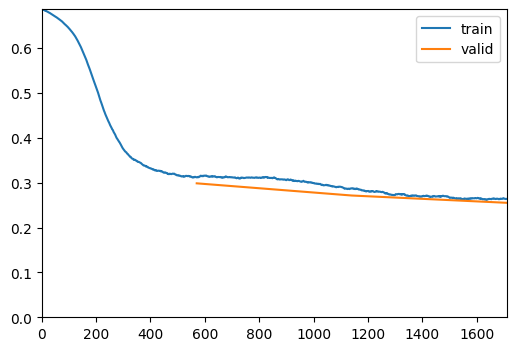

Better model found at epoch 1 with valid_loss value: 0.2715385854244232.
Better model found at epoch 1 with valid_loss value: 0.2715385854244232.
Better model found at epoch 1 with valid_loss value: 0.2715385854244232.
Better model found at epoch 2 with valid_loss value: 0.2552737295627594.
Better model found at epoch 2 with valid_loss value: 0.2552737295627594.
Better model found at epoch 2 with valid_loss value: 0.2552737295627594.


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.247892,0.246377,0.902863,0.239610,0.795512,07:59
1,0.243297,0.245140,0.902959,0.239396,0.799758,08:03
2,0.240369,0.245437,0.902027,0.253661,0.801319,08:03
3,0.236804,0.245397,0.902493,0.261749,0.799235,08:00
4,0.229778,0.245309,0.902233,0.289992,0.804253,08:03


Better model found at epoch 0 with valid_loss value: 0.2463771253824234.
Better model found at epoch 0 with valid_loss value: 0.2463771253824234.
Better model found at epoch 0 with valid_loss value: 0.2463771253824234.


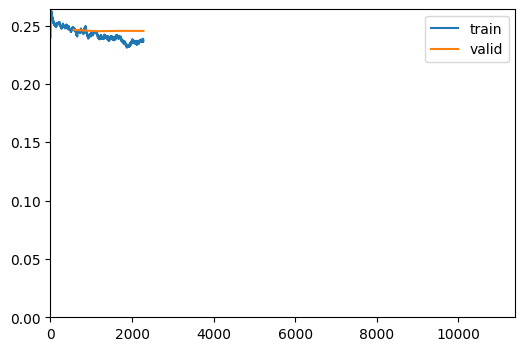

Better model found at epoch 1 with valid_loss value: 0.24514010548591614.
Better model found at epoch 1 with valid_loss value: 0.24514010548591614.
Better model found at epoch 1 with valid_loss value: 0.24514010548591614.
No improvement since epoch 1: early stopping


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase1-Done---------------
--------------Begin-Phase2---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.031490,0.030266,0.932767,0.275012,0.830451,18:02
1,0.030401,0.029609,0.932391,0.271604,0.837989,18:02
2,0.030005,0.029364,0.934772,0.284897,0.842430,18:16
3,0.029265,0.029299,0.935167,0.289191,0.843476,18:08


Better model found at epoch 0 with valid_loss value: 0.030266495421528816.
Better model found at epoch 0 with valid_loss value: 0.030266495421528816.
Better model found at epoch 0 with valid_loss value: 0.030266495421528816.


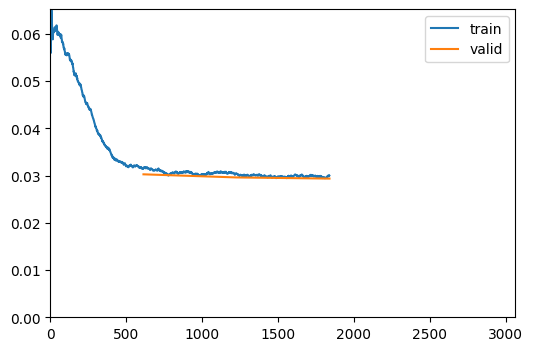

Better model found at epoch 1 with valid_loss value: 0.02960922382771969.
Better model found at epoch 1 with valid_loss value: 0.02960922382771969.
Better model found at epoch 1 with valid_loss value: 0.02960922382771969.
Better model found at epoch 2 with valid_loss value: 0.02936411090195179.
Better model found at epoch 2 with valid_loss value: 0.02936411090195179.
Better model found at epoch 2 with valid_loss value: 0.02936411090195179.
Better model found at epoch 3 with valid_loss value: 0.02929949201643467.
No improvement since epoch 0: early stopping


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase2-Done---------------
--------------Begin-Testing---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

ROC_AUC_Labels: [('Atelectasis', 0.8080169949229266), ('Consolidation', 0.7928948504728872), ('Infiltration', 0.7086733668790435), ('Pneumothorax', 0.8953149303798654), ('Edema', 0.8865522263192143), ('Emphysema', 0.9028328794149814), ('Fibrosis', 0.8688771615387169), ('Effusion', 0.897437529428512), ('Pneumonia', 0.7056565579405698), ('Pleural_Thickening', 0.8285730376854503), ('Cardiomegaly', 0.895895940928422), ('Nodule', 0.7490957838854054), ('Mass', 0.8528957023060797), ('Hernia', 0.9483802943287868)]
SCORE: 0.8386498040307758
Error in experiment: 'class_auc'

Experiment 2/4

=== Running experiment: momentum=0.99, k=3, threshold=0.2 ===
--------------Begin-Phase1---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

initial learning rate= 0.00019054606673307717


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.315862,0.299131,0.889591,0.005426,0.541637,08:28
1,0.286303,0.272384,0.893480,0.076798,0.715708,08:20
2,0.262215,0.254257,0.899657,0.206904,0.775846,08:18


Better model found at epoch 0 with valid_loss value: 0.29913127422332764.
Better model found at epoch 0 with valid_loss value: 0.29913127422332764.
Better model found at epoch 0 with valid_loss value: 0.29913127422332764.


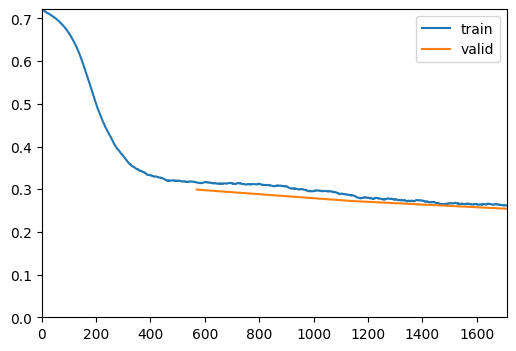

Better model found at epoch 1 with valid_loss value: 0.2723836600780487.
Better model found at epoch 1 with valid_loss value: 0.2723836600780487.
Better model found at epoch 1 with valid_loss value: 0.2723836600780487.
Better model found at epoch 2 with valid_loss value: 0.2542569637298584.
Better model found at epoch 2 with valid_loss value: 0.2542569637298584.
Better model found at epoch 2 with valid_loss value: 0.2542569637298584.


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.250057,0.246788,0.902246,0.229624,0.792345,08:19
1,0.244111,0.244965,0.901986,0.243870,0.799438,08:24
2,0.239943,0.243156,0.903260,0.256558,0.801271,08:20
3,0.236099,0.243939,0.904575,0.268178,0.800615,08:17
4,0.228450,0.247156,0.903356,0.274579,0.798926,08:16
5,0.226110,0.246484,0.902863,0.281702,0.805156,08:13


Better model found at epoch 0 with valid_loss value: 0.24678754806518555.
Better model found at epoch 0 with valid_loss value: 0.24678754806518555.
Better model found at epoch 0 with valid_loss value: 0.24678754806518555.


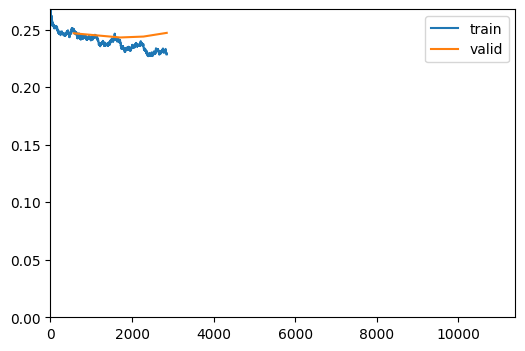

Better model found at epoch 1 with valid_loss value: 0.24496452510356903.
Better model found at epoch 1 with valid_loss value: 0.24496452510356903.
Better model found at epoch 1 with valid_loss value: 0.24496452510356903.
Better model found at epoch 2 with valid_loss value: 0.24315586686134338.
Better model found at epoch 2 with valid_loss value: 0.24315586686134338.
Better model found at epoch 2 with valid_loss value: 0.24315586686134338.
No improvement since epoch 2: early stopping


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase1-Done---------------
--------------Begin-Phase2---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.031161,0.030049,0.932741,0.292028,0.837680,18:05
1,0.030283,0.029336,0.933963,0.302908,0.840323,17:58
2,0.029541,0.029131,0.933658,0.294423,0.844978,17:53
3,0.028684,0.028968,0.935402,0.312162,0.848057,17:51
4,0.028331,0.029113,0.936001,0.309826,0.850642,17:48


Better model found at epoch 0 with valid_loss value: 0.030048711225390434.
Better model found at epoch 0 with valid_loss value: 0.030048711225390434.
Better model found at epoch 0 with valid_loss value: 0.030048711225390434.


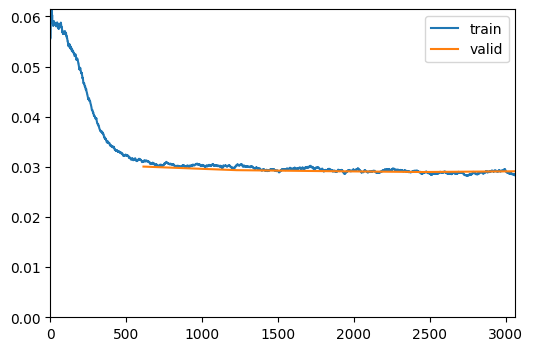

Better model found at epoch 1 with valid_loss value: 0.02933594398200512.
Better model found at epoch 1 with valid_loss value: 0.02933594398200512.
Better model found at epoch 1 with valid_loss value: 0.02933594398200512.
Better model found at epoch 2 with valid_loss value: 0.029131421819329262.
Better model found at epoch 2 with valid_loss value: 0.029131421819329262.
Better model found at epoch 2 with valid_loss value: 0.029131421819329262.
Better model found at epoch 3 with valid_loss value: 0.02896786481142044.
Better model found at epoch 3 with valid_loss value: 0.02896786481142044.
Better model found at epoch 3 with valid_loss value: 0.02896786481142044.


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase2-Done---------------
--------------Begin-Testing---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

ROC_AUC_Labels: [('Atelectasis', 0.8153740953900506), ('Consolidation', 0.798648893346148), ('Infiltration', 0.7169645448335291), ('Pneumothorax', 0.8859803976687093), ('Edema', 0.8948780714529173), ('Emphysema', 0.9218688569120684), ('Fibrosis', 0.8424010089946563), ('Effusion', 0.9083158131029423), ('Pneumonia', 0.7312036895577114), ('Pleural_Thickening', 0.8326501303382358), ('Cardiomegaly', 0.9151565864689617), ('Nodule', 0.778409904184069), ('Mass', 0.8717151467505242), ('Hernia', 0.9788899856424983)]
SCORE: 0.8494612231887874
Error in experiment: 'class_auc'

Experiment 3/4

=== Running experiment: momentum=0.99, k=4, threshold=0.2 ===
--------------Begin-Phase1---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

initial learning rate= 0.00019054606673307717


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.317529,0.299562,0.889248,0.000770,0.542714,08:15
1,0.290127,0.276745,0.893960,0.088636,0.689771,08:07
2,0.264986,0.256714,0.899411,0.181009,0.764403,08:02


Better model found at epoch 0 with valid_loss value: 0.29956233501434326.
Better model found at epoch 0 with valid_loss value: 0.29956233501434326.
Better model found at epoch 0 with valid_loss value: 0.29956233501434326.


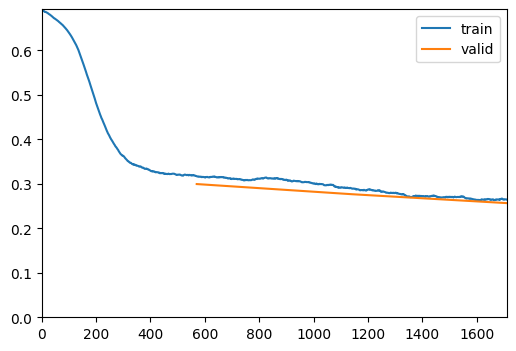

Better model found at epoch 1 with valid_loss value: 0.27674534916877747.
Better model found at epoch 1 with valid_loss value: 0.27674534916877747.
Better model found at epoch 1 with valid_loss value: 0.27674534916877747.
Better model found at epoch 2 with valid_loss value: 0.2567141354084015.
Better model found at epoch 2 with valid_loss value: 0.2567141354084015.
Better model found at epoch 2 with valid_loss value: 0.2567141354084015.


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.249697,0.249740,0.902219,0.233912,0.781831,08:07
1,0.244327,0.247294,0.902862,0.241384,0.787923,08:06
2,0.242840,0.245499,0.902808,0.246460,0.798548,08:11
3,0.236465,0.246443,0.902493,0.249891,0.802534,08:11
4,0.236362,0.245159,0.903671,0.277876,0.802583,08:06
5,0.229649,0.244184,0.903986,0.306984,0.800973,08:06
6,0.220882,0.246528,0.903493,0.318390,0.809002,08:03
7,0.211585,0.251054,0.902110,0.322517,0.804133,08:05
8,0.200316,0.253995,0.899521,0.343406,0.804405,08:08


Better model found at epoch 0 with valid_loss value: 0.2497396171092987.
Better model found at epoch 0 with valid_loss value: 0.2497396171092987.
Better model found at epoch 0 with valid_loss value: 0.2497396171092987.


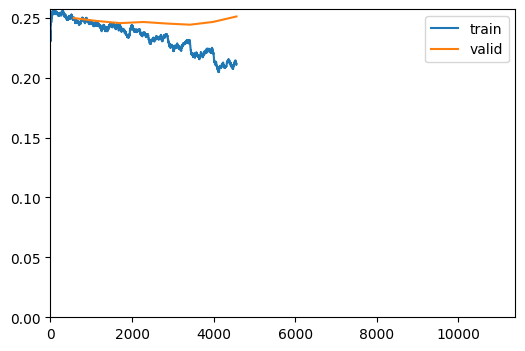

Better model found at epoch 1 with valid_loss value: 0.2472941279411316.
Better model found at epoch 1 with valid_loss value: 0.2472941279411316.
Better model found at epoch 1 with valid_loss value: 0.2472941279411316.
Better model found at epoch 2 with valid_loss value: 0.24549852311611176.
Better model found at epoch 2 with valid_loss value: 0.24549852311611176.
Better model found at epoch 2 with valid_loss value: 0.24549852311611176.
Better model found at epoch 4 with valid_loss value: 0.24515892565250397.
Better model found at epoch 4 with valid_loss value: 0.24515892565250397.
Better model found at epoch 4 with valid_loss value: 0.24515892565250397.
Better model found at epoch 5 with valid_loss value: 0.2441844493150711.
Better model found at epoch 5 with valid_loss value: 0.2441844493150711.
Better model found at epoch 5 with valid_loss value: 0.2441844493150711.
No improvement since epoch 5: early stopping


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase1-Done---------------
--------------Begin-Phase2---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.030035,0.028468,0.937478,0.351829,0.864144,17:57
1,0.029178,0.028066,0.938063,0.353283,0.870299,17:58
2,0.028543,0.027774,0.939381,0.368232,0.875421,18:00
3,0.027933,0.027522,0.937465,0.373726,0.878017,17:49


Better model found at epoch 0 with valid_loss value: 0.02846839837729931.
Better model found at epoch 0 with valid_loss value: 0.02846839837729931.
Better model found at epoch 0 with valid_loss value: 0.02846839837729931.


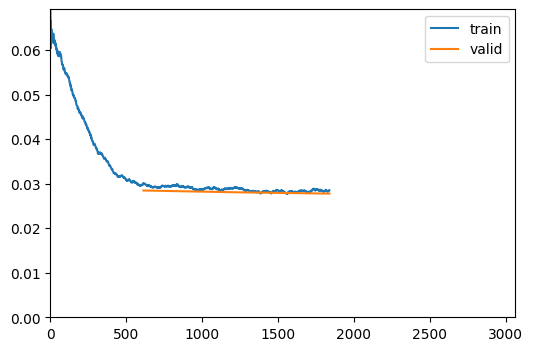

Better model found at epoch 1 with valid_loss value: 0.02806624211370945.
Better model found at epoch 1 with valid_loss value: 0.02806624211370945.
Better model found at epoch 1 with valid_loss value: 0.02806624211370945.
Better model found at epoch 2 with valid_loss value: 0.02777428738772869.
Better model found at epoch 2 with valid_loss value: 0.02777428738772869.
Better model found at epoch 2 with valid_loss value: 0.02777428738772869.
Better model found at epoch 3 with valid_loss value: 0.027522476390004158.
Better model found at epoch 3 with valid_loss value: 0.027522476390004158.
Better model found at epoch 3 with valid_loss value: 0.027522476390004158.
No improvement since epoch 0: early stopping


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase2-Done---------------
--------------Begin-Testing---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

ROC_AUC_Labels: [('Atelectasis', 0.8230890788023499), ('Consolidation', 0.8252907665092697), ('Infiltration', 0.7290405539953476), ('Pneumothorax', 0.9137066396806657), ('Edema', 0.9019892789638396), ('Emphysema', 0.9310544487572645), ('Fibrosis', 0.853407016495735), ('Effusion', 0.9111457409414934), ('Pneumonia', 0.8145338400427774), ('Pleural_Thickening', 0.863364094229717), ('Cardiomegaly', 0.9180657777137956), ('Nodule', 0.8250040056827286), ('Mass', 0.9079625262054508), ('Hernia', 0.9952440775305098)]
SCORE: 0.8723498461107818
Error in experiment: 'class_auc'

Experiment 4/4

=== Running experiment: momentum=0.99, k=5, threshold=0.2 ===
--------------Begin-Phase1---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

initial learning rate= 0.0002290867705596611


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.332695,0.317452,0.889344,0.000772,0.501462,08:19
1,0.304476,0.296250,0.889686,0.006814,0.606446,08:07
2,0.274170,0.267049,0.895398,0.129000,0.732828,07:57


Better model found at epoch 0 with valid_loss value: 0.3174523115158081.
Better model found at epoch 0 with valid_loss value: 0.3174523115158081.
Better model found at epoch 0 with valid_loss value: 0.3174523115158081.


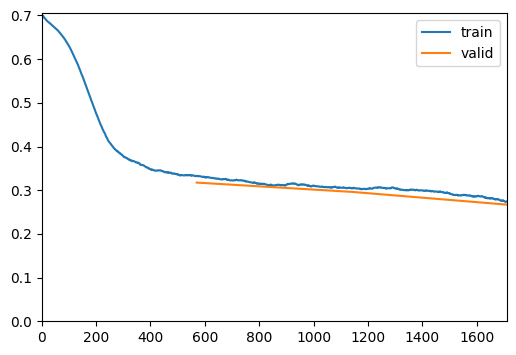

Better model found at epoch 1 with valid_loss value: 0.29625049233436584.
Better model found at epoch 1 with valid_loss value: 0.29625049233436584.
Better model found at epoch 1 with valid_loss value: 0.29625049233436584.
Better model found at epoch 2 with valid_loss value: 0.2670486271381378.
Better model found at epoch 2 with valid_loss value: 0.2670486271381378.
Better model found at epoch 2 with valid_loss value: 0.2670486271381378.


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.263637,0.257099,0.899959,0.184776,0.757328,08:03
1,0.257302,0.252503,0.901657,0.206615,0.774877,07:59
2,0.251788,0.250111,0.901794,0.227752,0.780270,08:01
3,0.247724,0.248552,0.901877,0.230480,0.789164,07:58
4,0.242867,0.247113,0.902616,0.240797,0.795388,08:00
5,0.237772,0.246961,0.902589,0.245257,0.797511,08:05
6,0.229861,0.246589,0.903191,0.301092,0.804911,07:58
7,0.222784,0.245976,0.903822,0.314154,0.806063,07:57
8,0.214780,0.250821,0.901424,0.318666,0.804599,07:57
9,0.204718,0.254083,0.902411,0.328286,0.798902,08:01


Better model found at epoch 0 with valid_loss value: 0.2570986747741699.
Better model found at epoch 0 with valid_loss value: 0.2570986747741699.
Better model found at epoch 0 with valid_loss value: 0.2570986747741699.


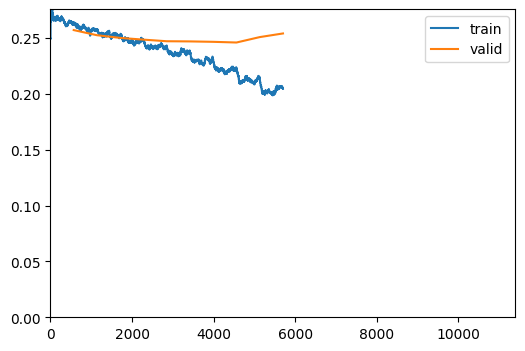

Better model found at epoch 1 with valid_loss value: 0.25250303745269775.
Better model found at epoch 1 with valid_loss value: 0.25250303745269775.
Better model found at epoch 1 with valid_loss value: 0.25250303745269775.
Better model found at epoch 2 with valid_loss value: 0.2501109838485718.
Better model found at epoch 2 with valid_loss value: 0.2501109838485718.
Better model found at epoch 2 with valid_loss value: 0.2501109838485718.
Better model found at epoch 3 with valid_loss value: 0.24855220317840576.
Better model found at epoch 3 with valid_loss value: 0.24855220317840576.
Better model found at epoch 3 with valid_loss value: 0.24855220317840576.
Better model found at epoch 4 with valid_loss value: 0.24711312353610992.
Better model found at epoch 4 with valid_loss value: 0.24711312353610992.
Better model found at epoch 4 with valid_loss value: 0.24711312353610992.
Better model found at epoch 5 with valid_loss value: 0.24696053564548492.
Better model found at epoch 5 with valid_

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase1-Done---------------
--------------Begin-Phase2---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.029402,0.027894,0.939133,0.371049,0.872317,17:59
1,0.028504,0.027591,0.942316,0.384654,0.873962,18:01
2,0.028078,0.027159,0.939184,0.398289,0.881254,17:55
3,0.027251,0.027115,0.940406,0.400257,0.880156,17:55


Better model found at epoch 0 with valid_loss value: 0.027894211933016777.
Better model found at epoch 0 with valid_loss value: 0.027894211933016777.
Better model found at epoch 0 with valid_loss value: 0.027894211933016777.


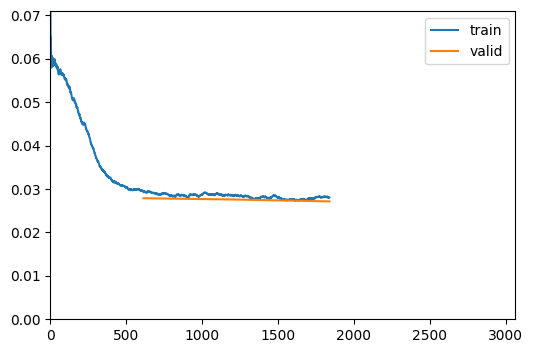

Better model found at epoch 1 with valid_loss value: 0.027591129764914513.
Better model found at epoch 1 with valid_loss value: 0.027591129764914513.
Better model found at epoch 1 with valid_loss value: 0.027591129764914513.
Better model found at epoch 2 with valid_loss value: 0.027159325778484344.
Better model found at epoch 2 with valid_loss value: 0.027159325778484344.
Better model found at epoch 2 with valid_loss value: 0.027159325778484344.
Better model found at epoch 3 with valid_loss value: 0.027115248143672943.
No improvement since epoch 0: early stopping


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

--------------Phase2-Done---------------
--------------Begin-Testing---------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: 

ROC_AUC_Labels: [('Atelectasis', 0.8333766499098691), ('Consolidation', 0.8193751479949299), ('Infiltration', 0.7392748233045947), ('Pneumothorax', 0.9082326043365004), ('Edema', 0.9184891395283983), ('Emphysema', 0.9456263001007913), ('Fibrosis', 0.8608682664542467), ('Effusion', 0.9169705331625111), ('Pneumonia', 0.7758288136887939), ('Pleural_Thickening', 0.8781900685482574), ('Cardiomegaly', 0.931487046601045), ('Nodule', 0.8301141886623157), ('Mass', 0.9090395702306079), ('Hernia', 0.9854181622397704)]
SCORE: 0.875163665340188
Error in experiment: 'class_auc'


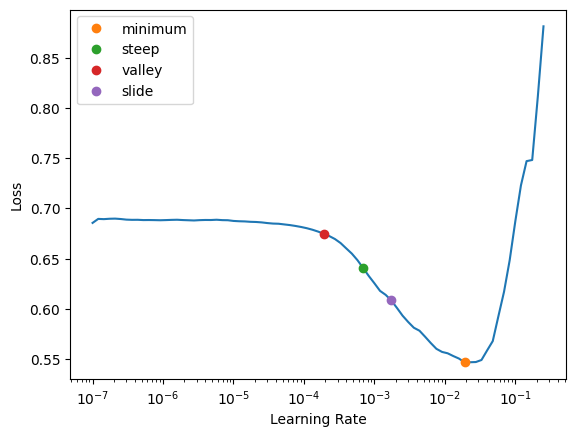

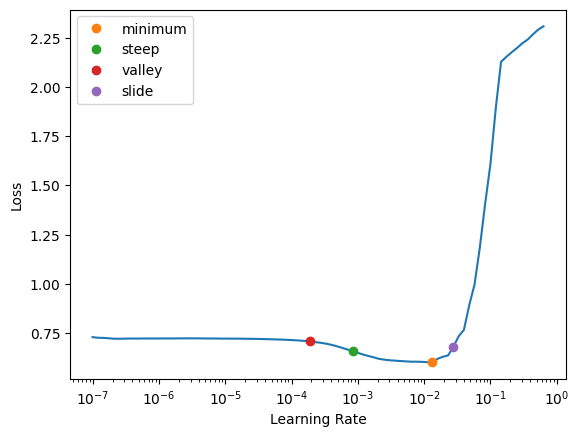

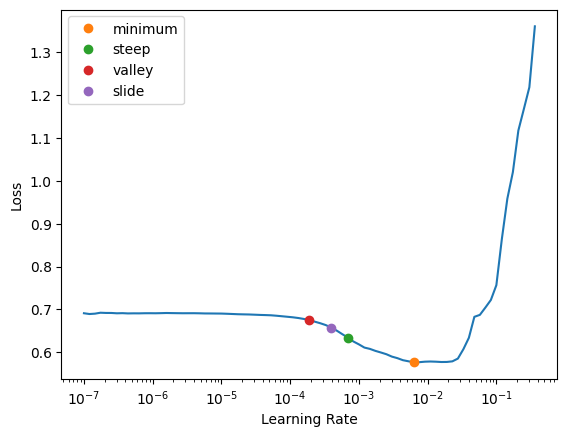

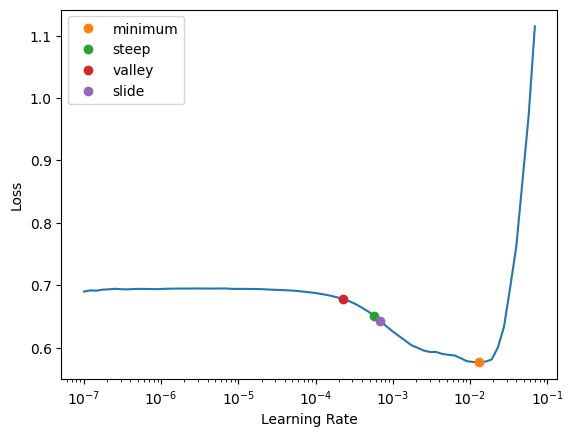

In [23]:
from fastai.vision.all import *
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import itertools
import time
import os


# Define the parameter grid
momentum_values = [0.99]
k_values = [2, 3, 4, 5]
threshold_values = [0.2]

# Define results directory
results_dir = '/kaggle/working/parameter_search_results'
os.makedirs(results_dir, exist_ok=True)

# Prepare to store results
results = []

# Define base callbacks for all runs
base_cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=3),
    ShowGraphCallback()
    ]
def run_experiment(momentum, k, threshold, exp_name):
    """Run a single experiment with specified parameters."""
    print(f"\n=== Running experiment: momentum={momentum}, k={k}, threshold={threshold} ===")
    
    # Modify the ModelConfig class attributes directly
    ModelConfig.MOMENTUM = momentum
    ModelConfig.RETRIEVAL_K = k
    ModelConfig.RARITY_THRESHOLD = threshold
    
    # Create a model-specific save callback
    save_cb = SaveModelCallback(monitor='valid_loss', min_delta=0.0001, 
                             fname=f"model_{exp_name}", with_opt=True)
    
    # Combine callbacks
    cbs = base_cbs + [save_cb]
    
    try:
        start_time = time.time()
        
        # Phase 1: Initial training
        print('--------------Begin-Phase1---------------')
        learn = create_fastai_learner(dls, cbs=cbs, loss_type='bce')
        
        # Find learning rate
        lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
        lr = lrs.valley if lrs.valley is not None else 1e-4
        print('initial learning rate=', lr)
        
        # Training
        learn.fine_tune(freeze_epochs=3, epochs=20, base_lr=lr)
        
        # Phase 2
        print('--------------Phase1-Done---------------')
        print('--------------Begin-Phase2---------------')
        learn = create_fastai_learner(dls_phase2, cbs=cbs, loss_type='asymmetric')
        learn = learn.load(f"/kaggle/working/models/model_{exp_name}")
        learn.unfreeze()
        learn.fit_one_cycle(5, slice(2e-5, 8e-5))
        
        # Testing phase
        print('--------------Phase2-Done---------------')
        print('--------------Begin-Testing---------------')
        test_learn = create_fastai_learner(dls_test, cbs=cbs, loss_type='asymmetric')
        test_learn = test_learn.load(f"/kaggle/working/models/model_{exp_name}")
        
        # Get results
        model_result = get_roc_auc(test_learn)
        preds = model_result['preds']
        auc_scores = model_result['class_auc']
        mean_auc = model_result['mean_auc']
        
        # Save predictions
        torch.save(preds, f'{results_dir}/preds_{exp_name}.pt')
        
        training_time = time.time() - start_time
        
        result = {
            'momentum': momentum,
            'k': k,
            'threshold': threshold,
            'mean_auc': mean_auc,
            'class_auc': auc_scores,
            'training_time': training_time,
            'exp_name': exp_name
        }
        
        print(f"Experiment completed. Mean AUC: {mean_auc:.4f}, Time: {training_time:.1f}s")
        return result
        
    except Exception as e:
        print(f"Error in experiment: {str(e)}")
        return {
            'momentum': momentum,
            'k': k,
            'threshold': threshold,
            'mean_auc': float('nan'),
            'class_auc': [],
            'training_time': float('nan'),
            'exp_name': exp_name,
            'error': str(e)
        }

# Main script
if __name__ == "__main__":
    # Get all parameter combinations
    all_combinations = list(itertools.product(momentum_values, k_values, threshold_values))
    total_experiments = len(all_combinations)
    
    print(f"Starting grid search with {total_experiments} parameter combinations")
    
    # Run all experiments
    for i, (momentum, k, threshold) in enumerate(all_combinations):
        exp_name = f"m{momentum}_k{k}_t{threshold}"
        print(f"\nExperiment {i+1}/{total_experiments}")
        
        result = run_experiment(momentum, k, threshold, exp_name)
        results.append(result)
        
        # Save intermediate results after each experiment
        pd.DataFrame(results).to_csv(f'{results_dir}/grid_search_results.csv', index=False)
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Find best parameters
    if not results_df.empty and not all(np.isnan(results_df['mean_auc'])):
        best_idx = results_df['mean_auc'].idxmax()
        best_params = results_df.iloc[best_idx]
        
        print("\n=== Best Parameter Combination ===")
        print(f"Momentum: {best_params['momentum']}")
        print(f"K-value: {best_params['k']}")
        print(f"Threshold: {best_params['threshold']}")
        print(f"Mean AUC: {best_params['mean_auc']:.4f}")
        print(f"Experiment name: {best_params['exp_name']}")
        
        # Create visualizations
        
        # 1. Heatmaps for each momentum value
        for m in momentum_values:
            df_m = results_df[results_df['momentum'] == m]
            if not df_m.empty:
                pivot = df_m.pivot_table(index='k', columns='threshold', values='mean_auc')
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
                plt.title(f'Mean AUC for Momentum = {m}')
                plt.tight_layout()
                plt.savefig(f'{results_dir}/heatmap_momentum_{m}.png')
                plt.close()
        
        # 2. Effect of individual parameters
        plt.figure(figsize=(18, 6))
        
        # Effect of momentum
        plt.subplot(1, 3, 1)
        momentum_effect = results_df.groupby('momentum')['mean_auc'].mean().reset_index()
        sns.barplot(x='momentum', y='mean_auc', data=momentum_effect)
        plt.title('Effect of Momentum')
        plt.ylim(momentum_effect['mean_auc'].min() * 0.99, momentum_effect['mean_auc'].max() * 1.01)
        
        # Effect of k
        plt.subplot(1, 3, 2)
        k_effect = results_df.groupby('k')['mean_auc'].mean().reset_index()
        sns.barplot(x='k', y='mean_auc', data=k_effect)
        plt.title('Effect of K Value')
        plt.ylim(k_effect['mean_auc'].min() * 0.99, k_effect['mean_auc'].max() * 1.01)
        
        # Effect of threshold
        plt.subplot(1, 3, 3)
        threshold_effect = results_df.groupby('threshold')['mean_auc'].mean().reset_index()
        sns.barplot(x='threshold', y='mean_auc', data=threshold_effect)
        plt.title('Effect of Threshold')
        plt.ylim(threshold_effect['mean_auc'].min() * 0.99, threshold_effect['mean_auc'].max() * 1.01)
        
        plt.tight_layout()
        plt.savefig(f'{results_dir}/parameter_effects.png')
        plt.close()
        
        # 3. Top 10 combinations
        top10 = results_df.nlargest(10, 'mean_auc')
        plt.figure(figsize=(14, 8))
        
        # Create labels for x-axis
        labels = [f"m={row['momentum']}\nk={row['k']}\nt={row['threshold']}" for _, row in top10.iterrows()]
        
        plt.bar(range(len(labels)), top10['mean_auc'])
        plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
        plt.title('Top 10 Parameter Combinations')
        plt.ylabel('Mean AUC')
        plt.tight_layout()
        plt.savefig(f'{results_dir}/top10_combinations.png')
        plt.close()
        

# Evaluation